In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha

set_matplotlib_config()
SAVE_DIR = Path('../figures/')

In [2]:
exp = xr.open_zarr(
    # '/net/argon/landclim/kraftb/machflow_engression/runs_expectiles/default/xval/fold_000/preds.zarr/'
    '/net/argon/landclim/kraftb/machflow_engression/runs_quantiles/default/xval/fold_000/preds.zarr/'
).isel(time=slice(365, None)).sel(time=slice('2017', '2022'))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod', 'P']].compute()

eng = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/'
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod', 'P']].compute()


/tmp/ipykernel_2383/4073388209.py:142: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


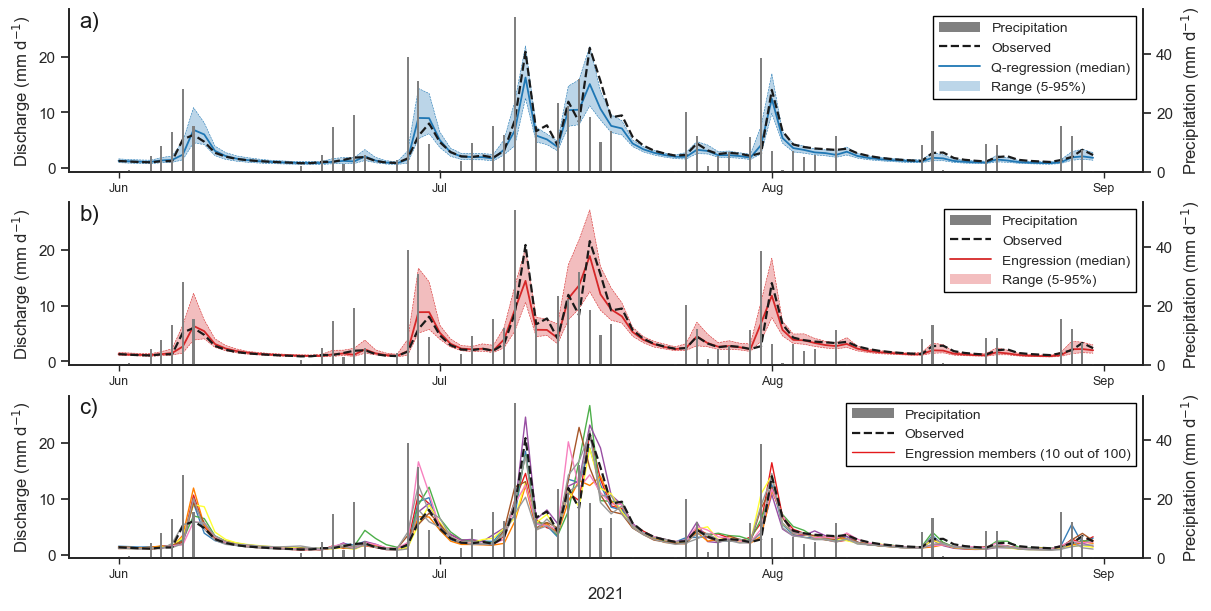

In [ ]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 1, wspace=0.0)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharey=ax0)
ax2 = fig.add_subplot(gs[2], sharey=ax0)

time = slice('2021-06', '2021-08')
station = 'CHFO-0090'

for i, (name, ds) in enumerate(zip(['Q-regression', 'Engression'], [exp, eng])):

    ax = [ax0, ax1][i]

    color = ['tab:blue', 'tab:red'][i]

    ds_sel = ds.sel(station=station, time=time)
    ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=1.6, label='Observed')

    if name == 'Engression':
        med = ds_sel.Qmm_mod.median('member')
        low = ds_sel.Qmm_mod.quantile(0.05, 'member')
        high = ds_sel.Qmm_mod.quantile(0.95, 'member')
    else:
        med = ds_sel.Qmm_mod.sel(member=0.5, method='nearest')
        low = ds_sel.Qmm_mod.sel(member=0.05, method='nearest')
        high = ds_sel.Qmm_mod.sel(member=0.95, method='nearest')

    ax.plot(ds_sel.time, med, lw=1.3, zorder=10, color=color, alpha=1.0, label=f'{name} (median)')
    ax.fill_between(ds_sel.time, low, high, ec='none', alpha=0.3, zorder=-10, fc=color, label='Range (5-95%)')
    ax.plot(ds_sel.time, low, lw=0.4, zorder=10, ls='--', color=color)
    ax.plot(ds_sel.time, high, lw=0.4, zorder=10, ls='--', color=color)

    ax_twin = ax.twinx()
    ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.5', ec='none', alpha=1.0, label='Precipitation', zorder=-10, width=0.2)

    ax.spines[['top']].set_visible(False)
    ax_twin.spines[['top']].set_visible(False)

    h0, l0 = ax.get_legend_handles_labels()
    h1, l1 = ax_twin.get_legend_handles_labels()

    handles = h1 + h0
    labels = l1 + l0

    legend = ax.legend(
        handles, labels,
        frameon=True,
        # loc='lower center',
        # bbox_to_anchor=(0.5, 1),
        # ncol=2 if i == 0 else 3,
        loc='upper right',
        bbox_to_anchor=(1.0, 1.0),
        ncol=1,
        columnspacing=1,
        handlelength=3)
    blend_legend_color_with_alpha(legend=legend, indices=[3], alpha=0.3)
    # ax.set_ylabel('Discharge (mm d$^{-1}$)')
    # ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

    # if i == 0:
    #     ax_twin.set_ylabel('')
    #     ax_twin.set_yticklabels([])
    # else:
    #     ax.set_ylabel('')

    ax.set_ylabel('Discharge (mm d$^{-1}$)')
    ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

    ax.set_rasterization_zorder(-5)

ax = ax2

color = 'tab:red'

ds_sel = eng.sel(station=station, time=time)
ax.plot(ds_sel.time, ds_sel.Qmm, zorder=20, color='k', ls='--', lw=1.6, label='Observed')

med = ds_sel.Qmm_mod.mean('member')
low = ds_sel.Qmm_mod.quantile(0.05, 'member')
high = ds_sel.Qmm_mod.quantile(0.95, 'member')

colormap = cm.Set1
num_members = 10
colors = [colormap(i / (num_members - 1)) for i in range(num_members)]
for m in range(num_members):
    ax.plot(
        ds_sel.time,
        ds_sel.Qmm_mod.isel(member=m),
        zorder=5,
        color=colors[m],
        ls='-',
        lw=1.,
        label=f'Engression members ({num_members} out of 100)' if m == 0 else None
    )

ax_twin = ax.twinx()
ax_twin.bar(ds_sel.time, ds_sel.P, fc='0.5', ec='none', alpha=1.0, label='Precipitation', zorder=-10, width=0.2)

ax.spines[['top']].set_visible(False)
ax_twin.spines[['top']].set_visible(False)

h0, l0 = ax.get_legend_handles_labels()
h1, l1 = ax_twin.get_legend_handles_labels()
handles = h1 + h0
labels = l1 + l0

ax.legend(
    handles, labels,
    frameon=True,
    # loc='lower center',
    # bbox_to_anchor=(0.5, 1),
    # ncol=2 if i == 0 else 3,
    loc='upper right',
    bbox_to_anchor=(1.0, 1),
    ncol=1,
    columnspacing=1,
    handlelength=3)

ax.set_ylabel('Discharge (mm d$^{-1}$)')
ax_twin.set_ylabel('Precipitation (mm d$^{-1}$)')

ax.set_rasterization_zorder(-5)

for ax, label in zip([ax0, ax1, ax2], ['a)', 'b)', 'c)']):
    ax.annotate(label, xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
                ha='left', va='top', color='k')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))  # newline to place it below

    # Set minor ticks to months
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    # Show both major and minor tick labels
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='x', which='minor', labelsize=9)

ax.set_xlabel('2021')

fig.autofmt_xdate()
fig.savefig(SAVE_DIR / 'time_series.eps', dpi=300, bbox_inches='tight')

In [ ]:
"""Implements common metrics for model evaluation."""

import numpy as np
import xarray as xr
from xarray.core.types import Dims


def common_mask(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims = None,
        drop_empty: bool = True) -> tuple[xr.DataArray, xr.DataArray]:
    """Apply common mask to two datasets, such that they have NaN values at the same locations.

    Args:
        obs (xr.DataArray): Observed data.
        mod (xr.DataArray): Modeled data.
        dim (Dims): Dimension(s) to apply the mask on. Default is None.
        drop_empty (bool): If True, drop dimensions where all values are NaN after masking
    """

    only_mod_dims = tuple(np.setdiff1d(np.array(mod.dims), np.array(obs.dims)))
    mask = mod.notnull().any(only_mod_dims) & obs.notnull()

    if drop_empty:
        all_miss = mask.any(dim).compute()
        mask = mask.where(all_miss, drop=True)

    obs = obs.where(mask).compute()
    mod = mod.where(mask).compute()

    return obs, mod


def _bias(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    bias = mod.mean(dim=dim, skipna=True) - obs.mean(dim=dim, skipna=True)

    return bias.compute()


def _relbias(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    relbias = (mod.mean(dim=dim, skipna=True) - obs.mean(dim=dim, skipna=True)) / obs.mean(dim=dim, skipna=True) * 100

    return relbias.compute()


def _absbias(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    absbias: xr.DataArray = np.abs(_bias(obs=obs, mod=mod, dim=dim))  # type: ignore

    return absbias.compute()


def _mse(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    return ((mod - obs)**2).mean(dim=dim).compute()


def _bias2(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    return _bias(obs=obs, mod=mod, dim=dim) ** 2


def _varerr(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    return (mod.std(dim=dim) - obs.std(dim=dim)) ** 2


def _phaseerr(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    return (1.0 - _r(obs=obs, mod=mod, dim=dim)) * 2.0 * mod.std(dim=dim) * obs.std(dim=dim)


def _rmse(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    return (_mse(obs=obs, mod=mod, dim=dim) ** 0.5).compute()


def _r(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    return xr.corr(obs, mod, dim=dim).compute()


def _nse(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    top = ((mod - obs)**2).sum(dim=dim, skipna=True)
    bottom = ((obs - obs.mean(dim=dim, skipna=True))**2).sum(dim=dim, skipna=True)

    nse = 1 - top / bottom

    nse = nse.where(mod.notnull().any(dim), np.nan)

    return nse.compute()


def _nnse(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    nse = _nse(obs=obs, mod=mod, dim=dim)

    return (1 / (2 - nse)).compute()


def _kge(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: Dims) -> xr.DataArray:

    r = _r(obs, mod, dim=dim)
    alpha = mod.std(dim=dim) / obs.std(dim=dim)
    beta = mod.mean(dim=dim) / obs.mean(dim=dim)

    value = ((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

    return (1 - value ** 0.5).compute()


def _get_sorted_fraction(x, fraction, direction):
    """Get a fraction of the smallest or largest values along the last axis.

    Note: Instead of cutting the fraction, we fill in NaNs to dead with different number of values.

    Args:
        x: a numpy array
        fraction: the fraction of lowest (if `direction='low'`) or highest (if `direction='high'`) values to extract.
        direction: 'low' for lowest or 'high' for largest values.

    Returns:
        A numpy Array with lowest or largest values up to given fraction, filled with NaN where above threshold.
    """

    if not (0 <= fraction <= 1):
        raise ValueError(
            f'fraction must be in range [0, 1], is {fraction}.'
        )

    for idx in np.ndindex(x.shape[:-1]):

        if direction == 'high':
            x_sorted = -np.sort(-x[idx])
        elif direction == 'low':
            x_sorted = np.sort(x[idx])
        else:
            raise ValueError(
                f'direcion mus be \'low\' or \'high\', is \'{direction}\'.'
            )

        num_valid = np.isfinite(x_sorted).sum()
        num_cut = np.round(fraction * num_valid).astype(int)
        x_sorted[-num_cut:] = np.nan

        x[idx] = x_sorted

    return x


def _get_xflow_bias(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: str,
        fraction: float,
        direction: str) -> xr.DataArray:

    obs = obs.transpose(..., dim)
    mod = mod.transpose(..., dim)

    obs_da, mod_da = common_mask(obs=obs, mod=mod, dim=dim, drop_empty=True)

    obs_s = _get_sorted_fraction(x=obs_da.values, fraction=fraction, direction=direction)
    mod_s = _get_sorted_fraction(x=mod_da.values, fraction=fraction, direction=direction)

    if direction == 'low':
        obs_s = np.log(obs_s.clip(1e-6, None))
        mod_s = np.log(mod_s.clip(1e-6, None))

    qsl = np.nansum(mod_s - np.nanmin(mod_s, axis=-1, keepdims=True), axis=-1)
    qol = np.nansum(obs_s - np.nanmin(obs_s, axis=-1, keepdims=True), axis=-1)

    res = -1 * (qsl - qol) / (qol + 1e-6)

    da_res = mod.isel({dim: 0}).drop_vars(dim).copy().load()
    da_res.values[:] = res * 100

    return da_res


def _flv(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: str) -> xr.DataArray:

    if not isinstance(dim, str):
        raise ValueError(
            '`flv` not implemented for more than on dimension.'
        )

    flv = _get_xflow_bias(obs=obs, mod=mod, dim=dim, fraction=0.3, direction='low').compute()
    flv = flv.where(mod.notnull().any(dim), np.nan)

    return flv


def _fhv(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: str) -> xr.DataArray:

    if not isinstance(dim, str):
        raise ValueError(
            '`fhv` not implemented for more than on dimension.'
        )

    fhv = _get_xflow_bias(obs=obs, mod=mod, dim=dim, fraction=0.02, direction='high').compute()
    fhv = fhv.where(mod.notnull().any(dim), np.nan)

    return fhv


def _fms(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: str,
        lower: float = 0.2,
        upper: float = 0.7) -> xr.DataArray:
    """%Bias of the middle section slope of the Flow Duration Curve (FMS).

    Implemented to match the behavior of `fdc_fms` from the other library, with
    the same defaults (lower=0.2, upper=0.7) and numerical safeguards.
    """
    if not isinstance(dim, str):
        raise ValueError(
            '`fms` not implemented for more than one dimension.'
        )

    if any([(x <= 0) or (x >= 1) for x in (lower, uper)]):
        raise ValueError("`lower` and `upper` must be in range ]0,1[")

    if lower >= upper:
        raise ValueError("`lower` must be smaller than `upper`.")

    # Move the target dimension to the last axis for easy numpy looping
    obs = obs.transpose(..., dim)
    mod = mod.transpose(..., dim)

    # Align NaNs between obs and mod and drop fully empty slices along `dim`
    obs_da, mod_da = common_mask(obs=obs, mod=mod, dim=dim, drop_empty=True)

    obs_vals = obs_da.values
    mod_vals = mod_da.values

    # Prepare result container (drop the time/flow dimension)
    da_res = mod.isel({dim: 0}).drop_vars(dim).copy().load()
    res = np.full(da_res.shape, np.nan, dtype=float)

    # Iterate over all leading indices; last axis is `dim`
    for idx in np.ndindex(obs_vals.shape[:-1]):
        o = obs_vals[idx]
        m = mod_vals[idx]

        # keep only valid (finite) pairs; after common_mask NaNs coincide
        valid = np.isfinite(o) & np.isfinite(m)
        o = o[valid]
        m = m[valid]

        n = o.size
        if n < 1:
            res[idx] = np.nan
            continue

        # Sorted (descending) FDCs
        o_sorted = -np.sort(-o)
        m_sorted = -np.sort(-m)

        # Numerical safeguards (match reference behavior)
        m_sorted[m_sorted <= 0] = 1e-6   # simulations: reset <= 0
        o_sorted[o_sorted == 0] = 1e-6   # observations: reset 0

        il = int(np.round(LOWER * n))
        iu = int(np.round(UPPER * n))

        # Indexing is safe since LOWER/UPPER in ]0,1[
        qsm_lower = np.log(m_sorted[il])
        qsm_upper = np.log(m_sorted[iu])
        qom_lower = np.log(o_sorted[il])
        qom_upper = np.log(o_sorted[iu])

        # Follow the reference implementation’s formula
        fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)
        res[idx] = fms * 100.0

    da_res.values[:] = res

    # Apply same masking convention as FLV/FHV and finalize
    da_res = da_res.where(mod.notnull().any(dim), np.nan)

    return da_res.compute()


METRIC_MAPPING: dict[str, dict] = dict(
    bias={'func': _bias, 'name': 'Bias', 'direction': 'none'},
    absbias={'func': _absbias, 'name': 'Absolute bias', 'direction': 'min'},
    relbias={'func': _relbias, 'name': '%Bias', 'direction': 'none'},
    mse={'func': _mse, 'name': 'Mean squared error', 'direction': 'min'},
    bias2={'func': _bias2, 'name': 'Squared bias', 'direction': 'min'},
    varerr={'func': _varerr, 'name': 'Variance error', 'direction': 'min'},
    phaseerr={'func': _phaseerr, 'name': 'Phase error', 'direction': 'min'},
    rmse={'func': _rmse, 'name': 'Root mean squared error', 'direction': 'min'},
    nse={'func': _nse, 'name': 'Modeling efficiency', 'direction': 'max'},
    nnse={'func': _nnse, 'name': 'Normalized modeling efficiency', 'direction': 'max'},
    kge={'func': _kge, 'name': 'Kling-Gupta efficiency', 'direction': 'max'},
    r={'func': _r, 'name': 'Pearson\'s correlation', 'direction': 'max'},
    flv={'func': _flv, 'name': '%Bias FLV', 'direction': 'none'},
    fhv={'func': _fhv, 'name': '%Bias FHV', 'direction': 'none'},
)


def compute_metrics(
        obs: xr.DataArray,
        mod: xr.DataArray,
        metrics: str | list[str] = 'all',
        dim: Dims = None,
        drop_empty: bool = True) -> xr.Dataset:
    """Compute metrics for model evaluation.

    Args:
        obs (xr.DataArray): Observed data.
        mod (xr.DataArray): Modeled data.
        metrics (str | list[str]): Metrics to compute. If 'all', computes all available metrics. Defaults to 'all'.
        dim (Dims): Dimension(s) to apply the metrics on. Default is None,
        drop_empty (bool): If True, drop dimensions where all values are NaN after masking. Defaults to True.

    Returns:
        xr.Dataset: Dataset containing computed metrics.

    """

    if metrics == 'all':
        metrics = list(METRIC_MAPPING.keys())

    if dim is None:
        dim = [str(dim) for dim in mod.dims if dim in obs.dims]

    metrics = [metrics] if isinstance(metrics, str) else metrics

    missing_metrics = []
    for metric in metrics:
        if metric not in METRIC_MAPPING:
            missing_metrics.append(metric)

    if len(missing_metrics) > 0:
        raise ValueError(
            f'the following metrics are not implemented: `{"`, `".join(missing_metrics)}`'
        )

    obs_da, mod_da = common_mask(obs=obs, mod=mod, dim=dim, drop_empty=drop_empty)

    ds = xr.Dataset()

    for metric in metrics:
        func = METRIC_MAPPING[metric]['func']
        name = METRIC_MAPPING[metric]['name']
        direction = METRIC_MAPPING[metric]['direction']

        da = func(obs=obs_da, mod=mod_da, dim=dim)

        da.attrs['long_name'] = name
        da.attrs['direction'] = direction

        ds[metric] = da

    return ds


In [208]:
def _get_sorted_fraction(x: np.ndarray, lower: float | None, upper: float | None):
    """Get a fraction of the smallest or largest values along the last axis.

    The function sets values outside of the range from lowest to highest values to NaN. If both lower and upper
    thresholds are provided, values below the lower and above the upper threshold are set to NaN. If only one of the
    thresholds is provided, values below the lower or above the upper threshold are set to NaN.

    Example:

    >>> RS = np.random.RandomState(0)
    >>> x = RS.permutation(np.arange(10.))
    >>> x
    array([2., 8., 4., 9., 1., 6., 7., 3., 0., 5.])
    >>> _get_sorted_fraction(x, None, 0.8)
    array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., nan, nan])
    >>> _get_sorted_fraction(x, 0.2, 0.8)
    array([nan, nan,  2.,  3.,  4.,  5.,  6.,  7., nan, nan])

    Args:
        x: a numpy array of which the last axis is sorted and cut.
        lower (float | None): the lower partition of lowest values to drop. E.g., for lower=0.2, the lowest 20% are
            set to NeN. If None, no lower partition is applied.
        upper (float | None): the upper partition of largest values to drop. E.g., for upper=0.2, the largest 20% are
            set to NeN. If None, no upper partition is applied.

    Returns:
        A numpy Array with lowest or largest values up to given fraction, filled with NaN where above threshold.
    """

    x = x.copy()

    if any([(x <= 0) or (x >= 1) for x in [upper, lower] if x is not None]):
        raise ValueError("upper and lower have to be in range ]0,1[")

    if lower is None and upper is None:
        raise ValueError("Either lower, upper, or both thresholds has to be provided.")

    if lower is not None and upper is not None:
        if lower >= upper:
            raise ValueError("The lower threshold has to be smaller than the upper.")

    for idx in np.ndindex(x.shape[:-1]):

        x_sorted = np.sort(x[idx])

        num_valid = np.isfinite(x_sorted).sum()

        if lower is not None:
            num_cut_lower = np.floor(lower * num_valid).astype(int)
            x_sorted[:num_cut_lower] = np.nan 

        if upper is not None:
            num_cut_upper = np.ceil(upper * num_valid).astype(int)
            x_sorted[num_cut_upper:] = np.nan 

        x[idx] = x_sorted

    return x


def _get_fdc_fraction(
        obs: xr.DataArray,
        mod: xr.DataArray,
        dim: str,
        lower: float | None,
        upper: float | None) -> tuple[np.ndarray, np.ndarray]:

    obs = obs.transpose(..., dim)
    mod = mod.transpose(..., dim)

    obs = obs.where(obs > 0, 1e-6)
    mod = mod.where(mod > 0, 1e-6)

    obs_da, mod_da = common_mask(obs=obs, mod=mod, dim=dim, drop_empty=True)

    obs_s = _get_sorted_fraction(x=obs_da.values, lower=lower, upper=upper)
    mod_s = _get_sorted_fraction(x=mod_da.values, lower=lower, upper=upper)

    return obs_s, mod_s

def flv(obs, mod, dim, lower: float = 0.3):
    """%Bias of the log-space low flow section of the Flow Duration Curve (FLV).

    Args:
        obs (xr.DataArray): Observed data.
        mod (xr.DataArray): Modeled data.
        dim (str): Dimension to apply the metric on.
        lower (float): Fraction of lowest values to consider. Default is 0.3 (30%).

    Returns:
        xr.DataArray: DataArray containing the FLV metric.
    """

    if not isinstance(dim, str):
        raise ValueError(
            '`flv` not implemented for more than on dimension.'
        )

    x_obs, x_mod = _get_fdc_fraction(obs=obs, mod=mod, dim=dim, lower=None, upper=lower)

    x_obs = np.log(x_obs)
    x_mod = np.log(x_mod)

    qol = np.nansum(x_obs - np.nanmin(x_obs, axis=-1, keepdims=True), axis=-1)
    qsl = np.nansum(x_mod - np.nanmin(x_mod, axis=-1, keepdims=True), axis=-1)

    flv = -1 * (qsl - qol) / (qol + 1e-6)
    flv *= 100

    da_res = mod.isel({dim: 0}).copy().load()
    da_res.values[:] = flv

    da_res.attrs['long_name'] = '%Bias FLV'
    da_res.attrs['direction'] = 'none'

    return da_res


def fhv(obs, mod, dim, upper: float = 0.02):
    """%Bias of the high flow section of the Flow Duration Curve (FHV).

    Args:
        obs (xr.DataArray): Observed data.
        mod (xr.DataArray): Modeled data.
        dim (str): Dimension to apply the metric on.
        upper (float): Fraction of upper values to consider. Default is 0.02 (top 2%).

    Returns:
        xr.DataArray: DataArray containing the FHV metric.
    """

    if not isinstance(dim, str):
        raise ValueError(
            '`fhv` not implemented for more than on dimension.'
        )

    x_obs, x_mod = _get_fdc_fraction(obs=obs, mod=mod, dim=dim, lower=1 - upper, upper=None)

    fhv = np.nansum(x_mod - x_obs, axis=-1) / (np.nansum(x_obs, axis=-1) + 1e-6)
    fhv *= 100

    da_res = mod.isel({dim: 0}).copy().load()
    da_res.values[:] = fhv

    da_res.attrs['long_name'] = '%Bias FHV'
    da_res.attrs['direction'] = 'none'

    return da_res


def fms(obs: xr.DataArray, mod: xr.DataArray, dim: str, lower: float = 0.2, upper: float = 0.3):
    """%Bias of the mid flow section of the Flow Duration Curve (FMS).

    Args:
        obs (xr.DataArray): Observed data.
        mod (xr.DataArray): Modeled data.
        dim (str): Dimension to apply the metric on.
        lower (float): Fraction of lower values to consider. Default is 0.2.
        upper (float): Fraction of upper values to consider. Default is 0.3.

    Returns:
        xr.DataArray: DataArray containing the FMS metric.
    """

    if not isinstance(dim, str):
        raise ValueError(
            '`fms` not implemented for more than on dimension.'
        )

    obs_fdc_mid, mod_fdc_mid = _get_fdc_fraction(obs=obs, mod=mod, dim=dim, lower=lower, upper=1 - upper)

    obs_fdc_mid = np.log(obs_fdc_mid)
    mod_fdc_mid = np.log(mod_fdc_mid)

    # Get lowest/hightes vales of FDV section.
    mod_lower = np.nanmin(mod_fdc_mid, axis=-1)
    obs_lower = np.nanmin(obs_fdc_mid, axis=-1)
    obs_upper = np.nanmax(obs_fdc_mid, axis=-1)
    mod_upper = np.nanmax(mod_fdc_mid, axis=-1)

    fms = ((mod_lower - mod_upper) - (obs_lower - obs_upper)) / (obs_lower - obs_upper + 1e-6)
    fms *= 100

    da_res = mod.isel({dim: 0}).copy().load()
    da_res.values[:] = fms

    da_res.attrs['long_name'] = '%Bias FMS'
    da_res.attrs['direction'] = 'none'

    return da_res



In [303]:
import numpy as np
import xarray as xr

def return_period_thresholds_from_ref(
    ref: xr.DataArray,
    dim: str = "time",
    T_edges_years = (0, 1, 2, 5, 10, 25, 50, np.inf),
    plotting: str = "weibull"  # or "gringorten"
) -> xr.Dataset:
    """
    Runoff thresholds at specified return-period edges (YEARS), per station,
    using rank-based interpolation. No fancy indexing; no coordinate conflicts.
    """

    # 1) station-wise sort in descending order, NaNs padded at the tail
    def _sort_desc_nanlast(a):
        # a is 1D along time
        finite = np.isfinite(a)
        q = a[finite]
        out = np.full_like(a, np.nan, dtype=float)
        if q.size:
            q_sorted = np.sort(q)[::-1]  # descending
            out[: q_sorted.size] = q_sorted
        return out

    Q_sorted = xr.apply_ufunc(
        _sort_desc_nanlast,
        ref,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    # counts and max empirical T (diagnostic)
    n = np.isfinite(Q_sorted).sum(dim=dim)
    Tmax_years = (n + 1) / 365.25  # for Weibull; still useful diagnostic

    # 2) target fractional ranks for T-edges
    T_edges = np.asarray(T_edges_years, dtype=float)
    with np.errstate(divide="ignore"):
        p_edges = 1.0 / (T_edges * 365.25)   # exceedance prob
    p_edges[~np.isfinite(p_edges)] = 0.0     # T=∞ -> p=0
    p_edges = np.clip(p_edges, 0.0, 1.0)

    if plotting.lower() == "weibull":
        # p = r/(n+1) -> r* = p*(n+1)
        def _r_targets(nn): return p_edges * (nn + 1.0)
    elif plotting.lower() == "gringorten":
        # p = (r-0.44)/(n+0.12) -> r* = p*(n+0.12)+0.44
        def _r_targets(nn): return p_edges * (nn + 0.12) + 0.44
    else:
        raise ValueError("plotting must be 'weibull' or 'gringorten'")

    # 3) interpolate Q at those (possibly fractional) ranks
    def _interp_Q_at_ranks(qvec, nn):
        # qvec: sorted desc with NaNs at tail; nn: scalar valid count
        if nn <= 0:
            return np.full(T_edges.shape, np.nan, float)
        q = qvec[: int(nn)]
        # target ranks (1-based), clamp to [1, nn]
        rstar = _r_targets(float(nn))
        rstar = np.clip(rstar, 1.0, float(nn))
        # 0-based fractional index in [0, nn-1]
        x = rstar - 1.0
        i0 = np.floor(x).astype(int)
        i1 = np.clip(i0 + 1, 0, int(nn) - 1)
        w = x - i0
        return (1.0 - w) * q[i0] + w * q[i1]

    Q_edges = xr.apply_ufunc(
        _interp_Q_at_ranks,
        Q_sorted,
        n,
        input_core_dims=[[dim], []],
        output_core_dims=[["edge"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    ).assign_coords(edge=("edge", [f"T={t:g}y" if np.isfinite(t) else "T=∞" for t in T_edges]))

    ds = xr.Dataset(
        dict(
            Q_edges=Q_edges,
            n_valid=n,
            Tmax_years=Tmax_years,
        )
    )
    ds["Q_edges"].attrs["note"] = "Runoff thresholds from reference FDC at return-period edges (years); rank interpolation."
    return ds


In [3]:
obs = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/harmonized_basins.zarr')
obs = obs.where((obs.folds > 0).compute(), drop=True)['Qmm'].compute()
obs

<xarray.DataArray 'Qmm' (station: 85, time: 23010)> Size: 8MB
array([[0.8953022 , 0.8953022 , 4.5907607 , ...,        nan,        nan,
               nan],
       [1.3629051 , 1.353819  , 1.34019   , ...,        nan,        nan,
               nan],
       [0.8171115 , 0.7717164 , 0.794414  , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.41773593, 0.41773593, 0.37596235, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 184kB 1961-01-01 1961-01-02 ... 2023-12-31

In [4]:
import numpy as np
import xarray as xr
from scipy.stats import genextreme


def fit_gev_and_return_levels(
    da: xr.DataArray,
    dim: str = "time",
    return_periods=(1, 5, 10, 20, 50, 100),
) -> xr.Dataset:
    """
    Fit GEV (Generalized Extreme Value) distribution to block maxima
    along `dim`, and compute return levels for given return periods.

    Parameters
    ----------
    da : xr.DataArray
        DataArray containing the variable of interest (e.g., annual maxima runoff).
    dim : str
        Dimension over which to fit the distribution (e.g., "time").
    return_periods : sequence of float
        Return periods in years for which to compute return levels.

    Returns
    -------
    xr.Dataset with variables:
        - shape, loc, scale : fitted GEV parameters
        - return_level : return level values (dims: other_dims..., return_period)
    """

    return_periods = np.asarray(return_periods, dtype=float)

    def _fit_gev(x):
        x = x[np.isfinite(x)]
        if x.size < 3:
            return np.nan, np.nan, np.nan
        shape, loc, scale = genextreme.fit(x)
        return shape, loc, scale

    def _rl(params):
        shape, loc, scale = params
        if np.isnan(shape):
            return np.full(return_periods.shape, np.nan)
        # isf(q) = inverse survival function, here q = 1/return_period
        return genextreme.isf(1.0 / return_periods, shape, loc, scale)

    # Fit parameters per station (or whatever other dims)
    params = xr.apply_ufunc(
        _fit_gev,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, float],
    )

    shape = params[0].rename("shape")
    loc = params[1].rename("loc")
    scale = params[2].rename("scale")

    # Compute return levels
    return_levels = xr.apply_ufunc(
        _rl,
        xr.concat([shape, loc, scale], dim="param"),
        input_core_dims=[["param"]],
        output_core_dims=[["return_period"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    ).assign_coords(return_period=("return_period", return_periods))

    return_levels.name = "return_level"

    ds = xr.Dataset(dict(shape=shape, loc=loc, scale=scale, return_level=return_levels))
    ds.attrs["note"] = "GEV fit per station; return levels via genextreme.isf(1/T)."
    return ds


In [19]:
periods = (5, 10, 20, 50, 100)
rlevels = fit_gev_and_return_levels(obs, return_periods=periods)

In [23]:
def bin_absolute_percentage_error(
    obs: xr.DataArray,
    mod: xr.DataArray,
    return_levels: xr.DataArray,
    edges=(0, 5, 10, 50, 100, np.inf),
) -> xr.DataArray:
    """
    Compute absolute percentage error per return-period bin.

    Parameters
    ----------
    obs, mod : xr.DataArray
        Observed and modelled flows (dims: station,time).
    return_levels : xr.DataArray
        Return levels (dims: station, return_period).
        Typically output of fit_gev_and_return_levels().
    edges : list
        Return period edges (years).

    Returns
    -------
    APE : xr.DataArray (dims: station, T_bin)
        Absolute percentage error per bin [%].
    """

    labels = []
    ape_bins = []

    for lo, hi in zip(edges[:-1], edges[1:]):
        # thresholds
        if lo == 0:
            lo_thr = xr.full_like(return_levels.isel(return_period=0), 0)
        else:
            lo_thr = return_levels.sel(return_period=lo)
        if np.isfinite(hi):
            hi_thr = return_levels.sel(return_period=hi)
        else:
            hi_thr = xr.full_like(return_levels.isel(return_period=0), np.inf)

        # mask values in bin
        obs_bin = obs.where((obs >= lo_thr) & (obs < hi_thr))
        mod_bin = mod.where((obs >= lo_thr) & (obs < hi_thr))

        # compute means
        obs_mean = obs_bin.mean(dim="time", skipna=True)
        mod_mean = mod_bin.mean(dim="time", skipna=True)

        # APE
        ape = 100.0 * np.abs(mod_mean - obs_mean) / obs_mean
        ape_bins.append(ape)

        if np.isinf(hi):
            labels.append(f"[{lo}, ∞)")
        else:
            labels.append(f"[{lo}, {hi})")

    APE = xr.concat(ape_bins, dim="T_bin").assign_coords(T_bin=("T_bin", labels))
    APE.name = "APE_bins"
    APE.attrs["units"] = "%"
    return APE

In [31]:
obs = eng.Qmm
mod = eng.Qmm_mod.mean('member')
eng_b = bin_absolute_percentage_error(obs=obs, mod=mod, return_levels=rlevels.return_level)
mod = exp.Qmm_mod.mean('member')
exp_b = bin_absolute_percentage_error(obs=obs, mod=mod, return_levels=rlevels.return_level)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


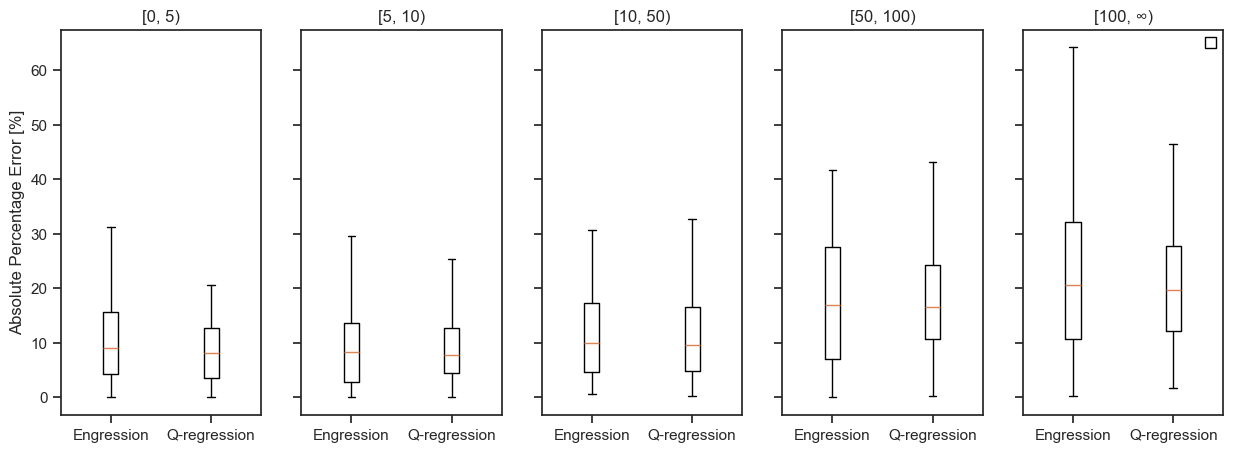

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

for i in range(5):
    ax = axes[i]
    eng_b_sel = eng_b.isel(T_bin=i).values
    exp_b_sel = exp_b.isel(T_bin=i).values
    m = np.isfinite(eng_b_sel) & np.isfinite(exp_b_sel)
    eng_b_sel = eng_b_sel[m]
    exp_b_sel = exp_b_sel[m]
    
    ax.boxplot(x=[eng_b_sel, exp_b_sel], positions=[0, 1], showfliers=False);
    ax.set_xticks([0, 1], ['Engression', 'Q-regression'])
    
    ax.set_title(eng_b.T_bin.values[i])
    if i == 0:
        ax.set_ylabel('Absolute Percentage Error [%]')
    if i == 4:
        ax.legend()

In [ ]:
m0 = (b0.Qmm - b0.Qmm_mod.median('member')).mean

<xarray.DataArray (station: 85, time: 2191)> Size: 745kB
array([[-0.09428501, -0.08744541, -0.07580382, ...,         nan,
                nan,         nan],
       [-0.1284445 , -0.15707237, -0.21630359, ..., -0.11480123,
        -0.10839665, -0.09875238],
       [-0.17152375, -0.18225789, -0.18712127, ..., -0.05130434,
        -0.08412373,  0.07921529],
       ...,
       [-0.16752395, -0.15544108, -0.09068826, ..., -1.1862297 ,
        -2.2506034 , -1.3414202 ],
       [-0.20458591, -0.20925826, -0.22787008, ...,         nan,
                nan,         nan],
       [-0.03497267, -0.03768975, -0.04159397, ..., -0.14451909,
        -0.12293029, -0.07921624]], dtype=float32)
Coordinates:
    beta     float64 8B 0.67
    esl      int64 8B 5
    nl       int64 8B 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 18kB 2017-01-01 2017-01-02 ... 2022-12-31

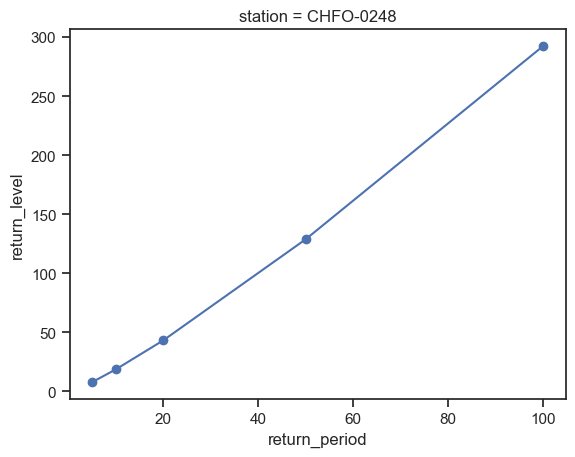

In [364]:
r.isel(station=80).return_level.plot.line(x='return_period', marker='o')

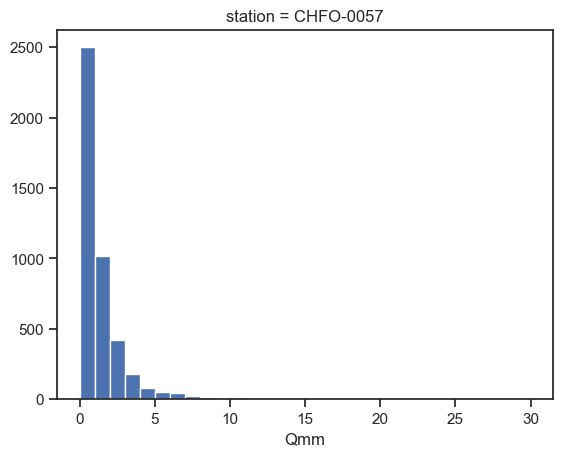

In [355]:
obs.isel(station=0).plot.hist(bins=np.linspace(0, 30, 31));

In [344]:
r = get_fdc_allstations(obs, dim="time")
r

<xarray.DataArray 'Qmm' (station: 85, time: 4383)> Size: 3MB
array([[2.51534214e+01, 2.37452431e+01, 2.21885376e+01, ...,
        3.90526243e-02, 3.46903652e-02, 3.21976431e-02],
       [6.02835655e+01, 4.94407463e+01, 3.91412697e+01, ...,
        5.58336794e-01, 5.51067948e-01, 5.31078696e-01],
       [2.97528458e+01, 2.85591831e+01, 2.72483997e+01, ...,
        3.75417352e-01, 3.65657419e-01, 3.60663950e-01],
       ...,
       [5.62246284e+01, 4.79759026e+01, 4.69520569e+01, ...,
        2.02837512e-01, 2.02837512e-01, 2.02837512e-01],
       [           nan,            nan,            nan, ...,
        2.38109484e-01, 2.33932123e-01, 2.29754761e-01],
       [1.16920097e+02, 6.73737335e+01, 5.96813011e+01, ...,
        7.07453310e-01, 7.05214560e-01, 5.84320664e-01]])
Coordinates:
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 35kB 2011-01-01 2011-01-02 ... 2022-12-31

In [343]:
return_period_thresholds(r).isel(station=0)

<xarray.DataArray 'Q_edges' (edge: 6)> Size: 48B
array([25.1534214 ,  0.07790738,  0.04634595,  0.03687398,  0.0330295 ,
        0.03219764])
Coordinates:
    station  <U9 36B 'CHFO-0057'
  * edge     (edge) <U5 120B 'T=0y' 'T=1y' 'T=2y' 'T=5y' 'T=10y' 'T=∞'
Attributes:
    note:     Runoff thresholds at return-period edges (years)

In [304]:
r = return_period_thresholds_from_ref(obs)

In [294]:
r = bias_per_return_period_bin_from_ref(eng.Qmm, eng.Qmm_mod.isel(member=0), ref=obs, dim='time')

ValueError: could not broadcast input array from shape (2188,) into shape (2191,)

In [283]:
r

<xarray.DataArray '%Bias per return-period bin' (T_bin: 7, station: 85)> Size: 2kB
array([[  3.9663715 ,  -1.4039222 ,   9.00417   ,   4.300019  ,
        -12.029398  ,  -8.567905  ,  -1.7887316 ,  -0.7445241 ,
         -5.9879947 ,  -2.4256217 ,  -3.0397124 ,  -6.887049  ,
         -7.696192  ,  -2.7326715 , -15.5017605 ,   7.011067  ,
         21.060192  ,  -5.0069866 ,   0.20225804, -10.583313  ,
        -17.652704  ,  -2.0117848 ,  14.1281395 ,   1.3051548 ,
        -13.0677185 ,  -1.6715344 ,   4.054461  ,   6.247203  ,
        -12.905578  ,  -3.6041265 ,   5.414796  , -19.682186  ,
        -14.398523  , -14.105577  ,   5.2762995 ,  -3.1339614 ,
         -2.1200125 ,  10.494912  ,   7.273531  , -11.510198  ,
          7.8716397 ,  11.976865  , -11.926391  ,   5.4072757 ,
         12.21516   ,  -4.373483  ,  -1.7108755 ,  -0.2851351 ,
        -17.076155  ,  -2.5868173 ,   5.9675694 ,   7.821514  ,
          5.8018312 ,  18.280624  ,   2.976775  ,  -7.013352  ,
         -5.507625  ,   3.245863  , -20.62377   ,  14.859529  ,
          8.360039  ,   1.6975933 ,  11.315734  ,  -8.618936  ,
         -2.6835423 ,  -8.958644  ,   3.8647401 ,  10.420529  ,
          2.925023  ,   1.7391181 ,  43.661438  ,  17.145992  ,
         -6.229749  ,  -7.8289647 , -10.530217  , -11.6054735 ,
         -4.40841   ,  -3.374002  , -22.149828  ,  -4.449508  ,
...
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan]], dtype=float32)
Coordinates:
    beta     float64 8B 0.67
    esl      int64 8B 5
    member   int64 8B 0
    nl       int64 8B 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * T_bin    (T_bin) <U8 224B '[0, 1)' '[1, 2)' ... '[25, 50)' '[50, ∞)'
Attributes:
    units:    %
    note:     Nonparametric plotting positions on daily data.

In [282]:
r.isel(T_bin=4)

<xarray.DataArray '%Bias per return-period bin' (station: 85)> Size: 340B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
    beta     float64 8B 0.67
    esl      int64 8B 5
    member   int64 8B 0
    nl       int64 8B 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
    T_bin    <U8 32B '[10, 25)'
Attributes:
    units:    %
    note:     Nonparametric plotting positions on daily data.

In [ ]:
lf

<xarray.DataArray 'Qmm_mod' (station: 85)> Size: 340B
array([ 6.1958633e+01,  8.2976875e+00,  1.9511116e+01,  9.3522408e+01,
        2.5347631e+01,  5.5124420e+01, -3.8511909e+01, -4.5279102e+01,
       -1.5602686e+01,  2.4611605e+01,  3.4822319e+00,  3.6262741e+01,
        1.5351005e+01, -4.2515541e+01,  5.8252724e+01, -5.6365990e+01,
       -9.5616894e+00,  4.7928375e+01,  3.9089169e+01,  2.3943623e+01,
        1.2789592e+01, -2.8864183e+01,  5.1470478e+01,  1.4342136e+01,
        8.1797826e-01,  7.2578339e+01,  5.2395767e+01, -2.1925549e+01,
        3.6869389e+01,  3.4433872e+01, -5.5762909e+01, -2.9782546e+00,
        2.0526621e+01,  2.3205863e-01, -3.9552968e+00,  4.1672034e+00,
        1.2151049e+01,  5.1461636e+01,  7.3756552e+00,  6.0611870e+01,
        5.4826576e+01, -1.9393728e+01,  2.0799648e+01,  1.5744517e+00,
        7.7695312e+01,  3.4464310e+01, -1.6534233e+01,  7.0058128e+01,
        6.8155174e+01, -3.6616196e+01,  1.8247049e+01,  7.7714592e+01,
       -1.8939695e+01, -2.0623289e+01,  1.4340379e+01, -1.3378681e+00,
       -1.7325691e+01,  1.4863333e+01,  9.9172382e+00,  4.3573928e+00,
        2.2858133e+01,  3.4696095e+01,  3.4903084e+01,  3.1922930e+01,
        7.5214996e+01, -9.2155542e+00, -2.4126532e+01, -1.3408211e+02,
       -1.3760802e-01,  3.6173492e+01, -3.7522026e+01, -2.7966993e+01,
       -4.5411625e+01, -8.9011440e+00,  2.7037277e+01,  4.1939816e+01,
        9.1908165e+01,  1.0174548e+01, -3.2971157e+01,  3.3558064e+01,
        2.4276682e+01,  6.9556725e+01,  1.9923959e+00, -4.7272366e+10,
       -2.0000797e+01], dtype=float32)
Coordinates:
    beta     float64 8B 0.67
    esl      int64 8B 5
    nl       int64 8B 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
    time     datetime64[ns] 8B 2017-01-01
Attributes:
    long_name:  %Bias FLV
    direction:  none

In [231]:
x = np.arange(1., 20.)
y = x.copy()
y[0] = -1

obs = xr.DataArray(x.reshape(1, -1), dims=['station', 'time'])
mod = xr.DataArray(y.reshape(1, -1), dims=['station', 'time'])

lf = flv(obs, mod, dim='time', lower=0.3)
hf = fhv(obs, mod, dim='time', upper=0.02)
mf = fms(obs, mod, dim='time', lower=0.2, upper=0.3)

In [232]:
mf

<xarray.DataArray (station: 1)> Size: 8B
array([-0.])
Dimensions without coordinates: station
Attributes:
    long_name:  %Bias FMS
    direction:  none

In [233]:
lf

<xarray.DataArray (station: 1)> Size: 8B
array([-1049.9301526])
Dimensions without coordinates: station
Attributes:
    long_name:  %Bias FLV
    direction:  none

In [234]:
hf

<xarray.DataArray (station: 1)> Size: 8B
array([0.])
Dimensions without coordinates: station
Attributes:
    long_name:  %Bias FHV
    direction:  none

In [110]:
_get_xflow_bias(obs, mod, dim='time', lower=0.2, upper=0.7)

<xarray.DataArray (station: 1)> Size: 8B
array([-99.99999])
Dimensions without coordinates: station

In [245]:
mod = eng.Qmm_mod.median('member').compute()
eng_lf = flv(eng.Qmm, mod, dim='time', lower=0.3)
eng_hf = fhv(eng.Qmm, mod, dim='time', upper=0.02)
eng_mf = fms(eng.Qmm, mod, dim='time', lower=0.2, upper=0.3)
mod = exp.Qmm_mod.sel(member=0.5).compute()
exp_lf = flv(exp.Qmm, mod, dim='time', lower=0.3)
exp_hf = fhv(exp.Qmm, mod, dim='time', upper=0.02)
exp_mf = fms(exp.Qmm, mod, dim='time', lower=0.2, upper=0.3)

In [260]:
x = np.linspace(-100, 100, 21)

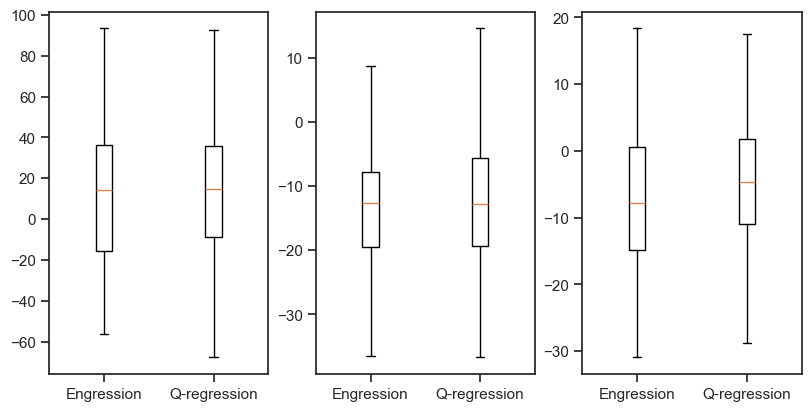

In [270]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)

for ax, metric, eng_metric, exp_metric in zip(axes, ['FLV', 'FHV', 'FMS'], [eng_lf, eng_hf, eng_mf], [exp_lf, exp_hf, exp_mf]):

    ax.boxplot(x=[eng_metric.values, exp_metric.values], positions=[0, 1], showfliers=False);
    ax.set_xticks([0, 1], ['Engression', 'Q-regression'])

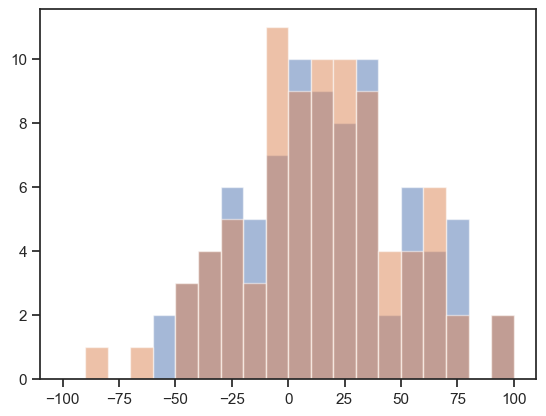

In [262]:
plt.hist(eng_lf.values, bins=x, alpha=0.5);
plt.hist(exp_lf.values, bins=x, alpha=0.5);

(-100.0, 100.0)

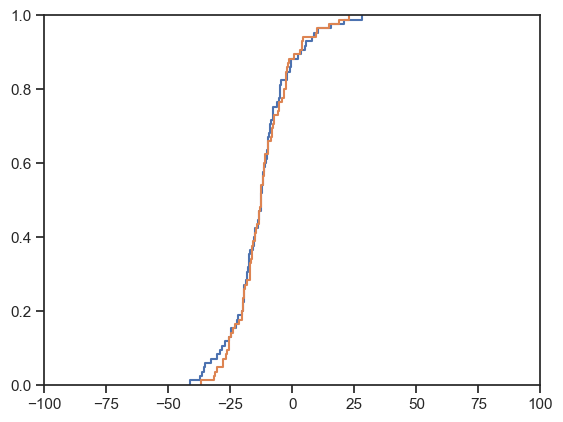

In [247]:
plt.ecdf(eng_hf.values)
plt.ecdf(exp_hf.values)
plt.xlim(-100, 100)

(-100.0, 100.0)

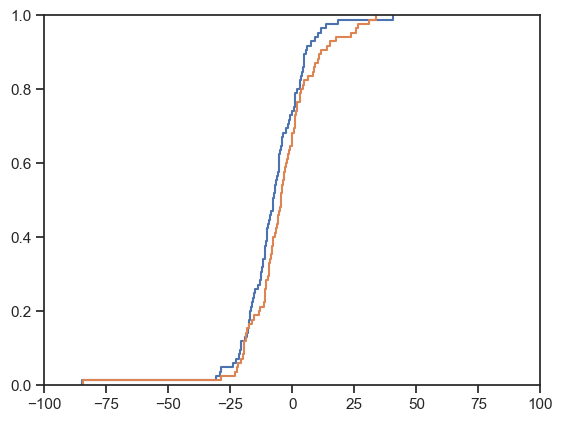

In [248]:
plt.ecdf(eng_mf.values)
plt.ecdf(exp_mf.values)
plt.xlim(-100, 100)

In [3]:
eng

<xarray.Dataset> Size: 76MB
Dimensions:  (station: 85, time: 2191, member: 100)
Coordinates:
    beta     float64 8B 0.67
    esl      int64 8B 5
  * member   (member) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
    nl       int64 8B 100
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 18kB 2017-01-01 2017-01-02 ... 2022-12-31
Data variables:
    Qmm      (station, time) float32 745kB 0.4609 0.44 0.4693 ... 1.251 1.243
    Qmm_mod  (member, station, time) float32 74MB 0.5994 0.5568 ... 1.117 1.151
    P        (station, time) float32 745kB 0.0 0.13 0.02 1.12 ... 1.05 2.62 0.65

In [8]:
engm = compute_metrics(eng.Qmm, eng.Qmm_mod, dim='time', metrics=['fhv', 'flv', 'kge'])
expm = compute_metrics(exp.Qmm, exp.Qmm_mod, dim='time', metrics=['fhv', 'flv', 'kge'])

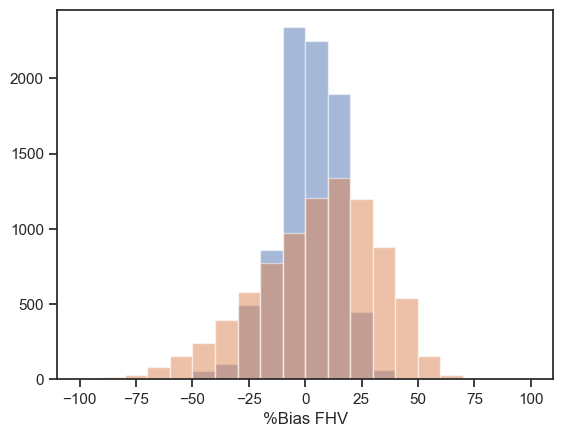

In [13]:
engm.fhv.plot.hist(bins=np.linspace(-100, 100, 21), alpha=0.5);
expm.fhv.plot.hist(bins=np.linspace(-100, 100, 21), alpha=0.5);

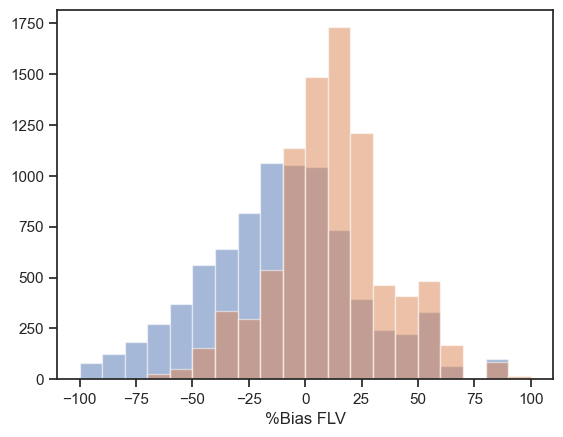

In [14]:
engm.flv.plot.hist(bins=np.linspace(-100, 100, 21), alpha=0.5);
expm.flv.plot.hist(bins=np.linspace(-100, 100, 21), alpha=0.5);

In [3]:
notnull = eng.Qmm.notnull().all('time').compute()
eng_notnull = eng.where(notnull, drop=True).isel(time=slice(None, -1))

In [12]:
d = ((eng_notnull.Qmm_mod - eng_notnull.Qmm_mod.median('member')) >= 0).sum('time') / len(eng_notnull.time)

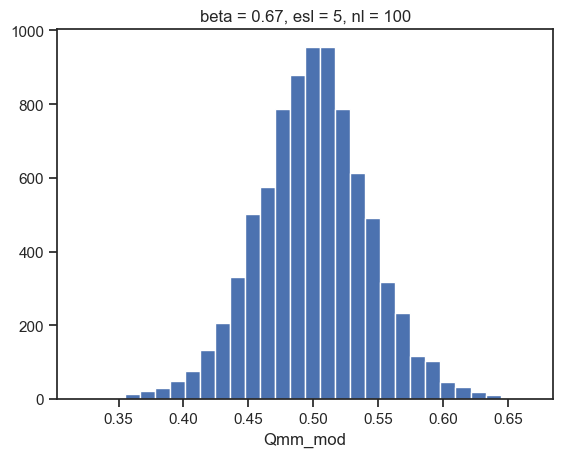

In [13]:
d.plot.hist(bins=30);

In [4]:
v = eng_notnull.Qmm_mod.values.transpose(2, 0, 1).reshape(-1, 10, 100, 83).transpose(3, 2, 0, 1)
vs = np.cumsum(v - v[:, :, :, [0]], -1).mean(-1)

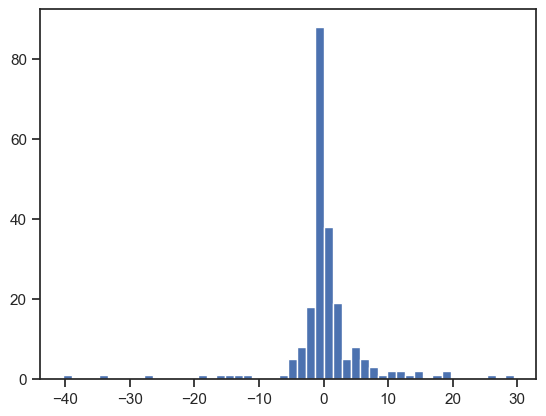

In [94]:
plt.hist(vs[0, 0, ...], bins=50);

In [10]:
r_t   = resid.isel(time=slice(1, None))
r_tm1 = resid.isel(time=slice(0, -1))

In [11]:
# means (along time axis)
mean_r = resid.mean(dim="time")

# anomalies
an_t   = r_t   - mean_r
an_tm1 = r_tm1 - mean_r

# numerator and denominator
num = (an_t * an_tm1).sum(dim="time")
den = (an_t**2).sum(dim="time")

rho1 = num / den

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 8.000e+00, 1.500e+01,
        2.000e+01, 3.600e+01, 6.600e+01, 1.500e+02, 4.430e+02, 7.738e+03]),
 array([0.98063087, 0.98127657, 0.98192227, 0.98256797, 0.9832136 ,
        0.9838593 , 0.984505  , 0.98515069, 0.98579639, 0.98644209,
        0.98708779, 0.98773348, 0.98837912, 0.98902482, 0.98967052,
        0.99031621, 0.99096191, 0.99160761, 0.9922533 , 0.99289894,
        0.99354464, 0.99419034, 0.99483603, 0.99548173, 0.99612743,
        0.99677312, 0.99741882, 0.99806446, 0.99871016, 0.99935585,
        1.00000155]),
 <BarContainer object of 30 artists>)

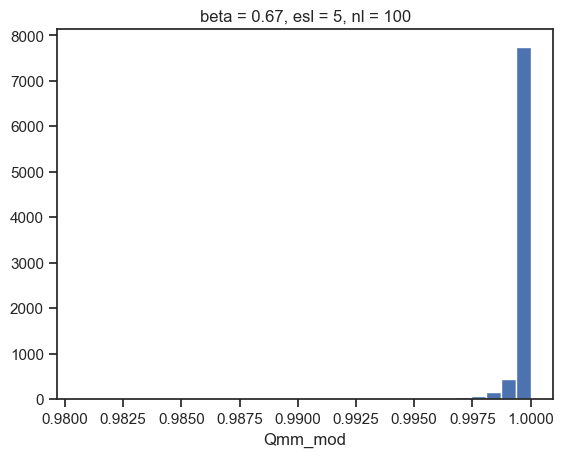

In [13]:
rho1.plot.hist(bins=30)

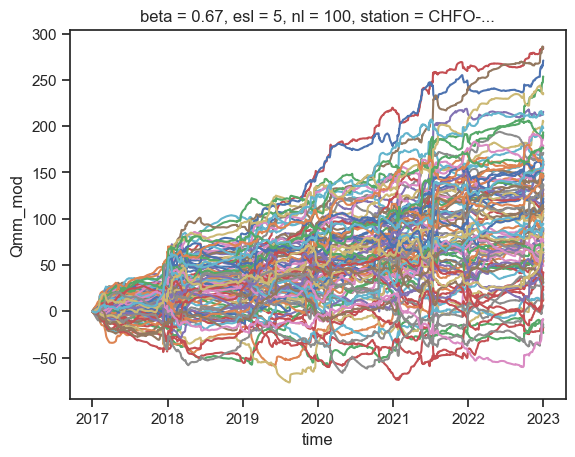

In [24]:
resid.isel(station=0).cumsum('time').plot.line(x='time', add_legend=False);